# Conditional Density Estimation Demo

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML

from stellarperceptron.ddpm import ConditionalDiffusionModel

device = "cuda:1"

nn_model = ConditionalDiffusionModel(
    dim=2, cond_dim=6, dense_num=128, n_layers=4, num_steps=100, beta_end=5.0e-2, device=device
)


def sampling(x1, y1, s1, x2, y2, s2, n=1000):
    x1 = np.concatenate([np.random.normal(x1, s1, n), np.random.normal(y1, s2, n)])
    x2 = np.concatenate([np.random.normal(x2, s1, n), np.random.normal(y2, s2, n)])
    r = np.random.choice([0, 1], 1)[0]
    if r == 0:
        return x1
    else:
        return x2


dataset = np.zeros((100000, 2))
# composed of two gaussian, cond is [x_1, y_1, s_1, x_2, y_2, s_2]
cond = np.column_stack(
    [
        np.random.uniform(-2.0, 2.0, (100000, 2)),
        np.random.uniform(0.1, 0.5, (100000)),
        np.random.uniform(-2.0, 2.0, (100000, 2)),
        np.random.uniform(0.1, 0.5, (100000)),
    ]
)

for i in range(len(dataset)):
    dataset[i] = sampling(*cond[i], n=1)

dataset = torch.tensor(dataset, dtype=torch.float32).to(device)
cond = torch.tensor(cond, dtype=torch.float32).to(device)


c:\Users\Henry\Documents\Github\stars_foundation_diffusion\stellarperceptron\ddpm.py:44: UserWarning: In ideal case, cond_dim equals to dim_out. Now cond_dim (6) is linearly mapped to dim_out (128) so you have additional trainable parameters.
  warnings.warn(


## Training

tensor(0.3955, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.5882, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.4624, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.7201, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.4674, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.3799, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.5930, device='cuda:1', grad_fn=<MulBackward0>)
tensor(0.2405, device='cuda:1', grad_fn=<MulBackward0>)


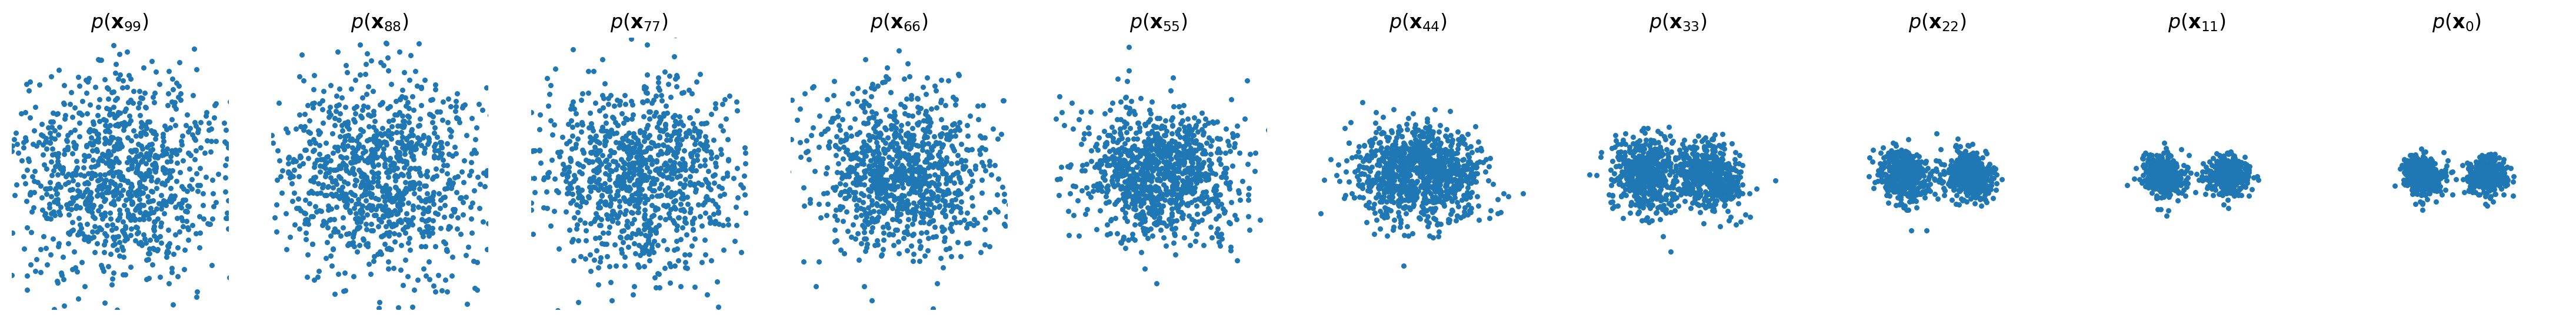

In [2]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
batch_size = 128

for t in range(256):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i : i + batch_size]
        batch_x = dataset[indices]
        batch_cond = cond[indices]
        # Compute the loss.
        loss = nn_model.noise_estimation_loss(batch_x, batch_cond)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Calling the step function to update the parameters
        optimizer.step()
        # Print loss
    if t % 32 == 0:
        print(loss)
with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000,
        cond=torch.tensor([[-0.5, 0.0, 0.1, 0.5, 0.0, 0.1]]).to(device),
        return_steps=True,
    ).cpu()
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )
    axs[i].set_xlim(-2, 2)
    axs[i].set_ylim(-2, 2)


## Example code to animate

In [4]:
with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000,
        cond=torch.tensor([[-0.5, 0.0, 0.1, 0.5, 0.0, 0.1]]).to(device),
        return_steps=True,
    ).cpu()
    
fig, ax = plt.subplots(figsize=(4, 4), dpi=144)
cur_x = x_seq[0]
scat = ax.scatter(cur_x[:, 0], cur_x[:, 1], s=5)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()
ax.axis("equal")
ax.set_title(f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$")


def animate(ii):
    cur_x = x_seq[ii]
    scat.set_offsets(np.column_stack([cur_x[:, 0], cur_x[:, 1]]))
    ax.set_title(f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[ii].cpu()[0])}}})$")
    return (scat,)


anim = animation.FuncAnimation(
    fig,
    animate,  # init_func=init_anim_frame,
    frames=100,
    interval=200,
    blit=True,
    repeat=True,
)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out = HTML(anim.to_html5_video())
plt.close()
out


## Testing a few conditions

Each condition composed of two gaussian, and is [$x_1, y_1, \sigma_1, x_2, y_2, \sigma_2$]

(-2.0, 2.0)

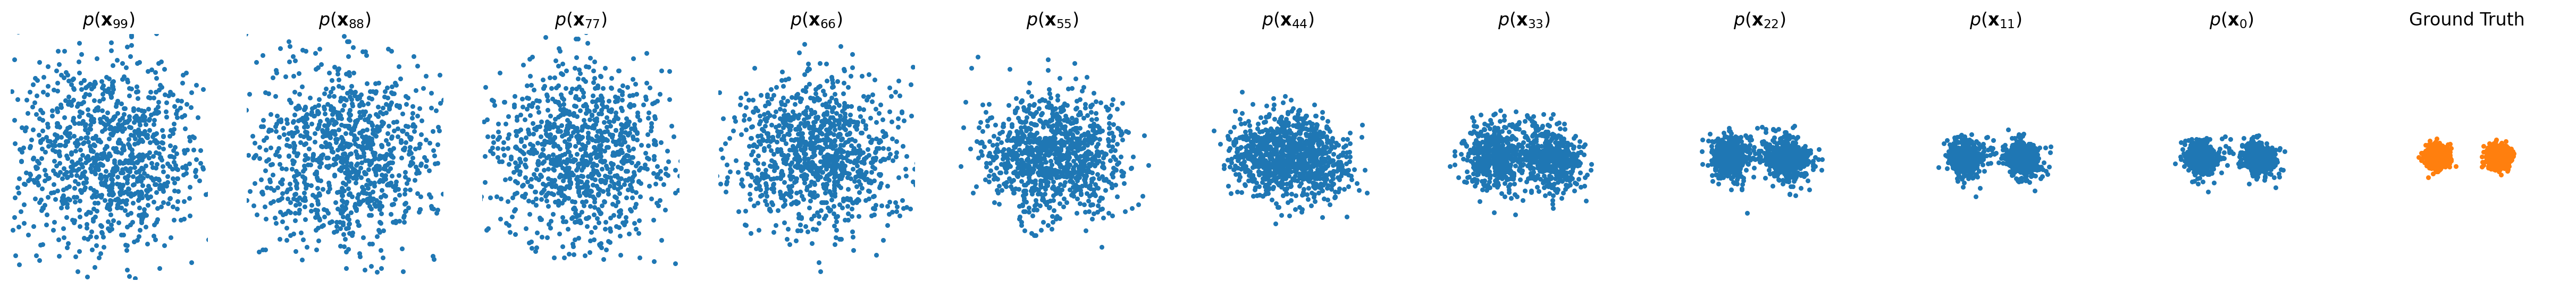

In [3]:
ground_cond = [-0.5, 0.0, 0.1, 0.5, 0.0, 0.1]

with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000, cond=torch.tensor([ground_cond]).to(device), return_steps=True
    ).cpu()

fig, axs = plt.subplots(1, 11, figsize=(31, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )
    axs[i].set_xlim(-2, 2)
    axs[i].set_ylim(-2, 2)

xy = np.stack([sampling(*ground_cond, n=1) for _ in range(1000)])
axs[-1].scatter(xy[:, 0], xy[:, 1], s=5, c="C1")
axs[-1].set_axis_off()
axs[-1].axis("equal")
axs[-1].set_title("Ground Truth")
axs[-1].set_xlim(-2, 2)
axs[-1].set_ylim(-2, 2)


(-4.0, 4.0)

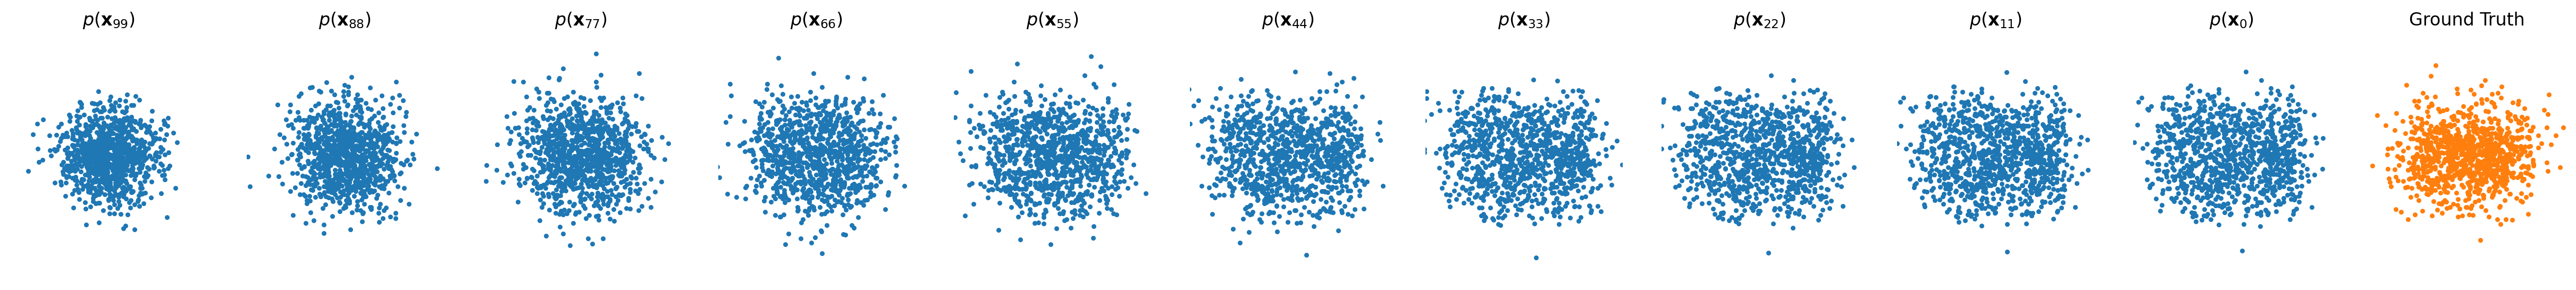

In [5]:
ground_cond = [-1.0, 0.0, 1.0, 1.0, 0.0, 1.0]

with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000, cond=torch.tensor([ground_cond]).to(device), return_steps=True
    ).cpu()

fig, axs = plt.subplots(1, 11, figsize=(31, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )
    axs[i].set_xlim(-4, 4)
    axs[i].set_ylim(-4, 4)

xy = np.stack([sampling(*ground_cond, n=1) for _ in range(1000)])
axs[-1].scatter(xy[:, 0], xy[:, 1], s=5, c="C1")
axs[-1].set_axis_off()
axs[-1].axis("equal")
axs[-1].set_title("Ground Truth")
axs[-1].set_xlim(-4, 4)
axs[-1].set_ylim(-4, 4)


(-2.0, 2.0)

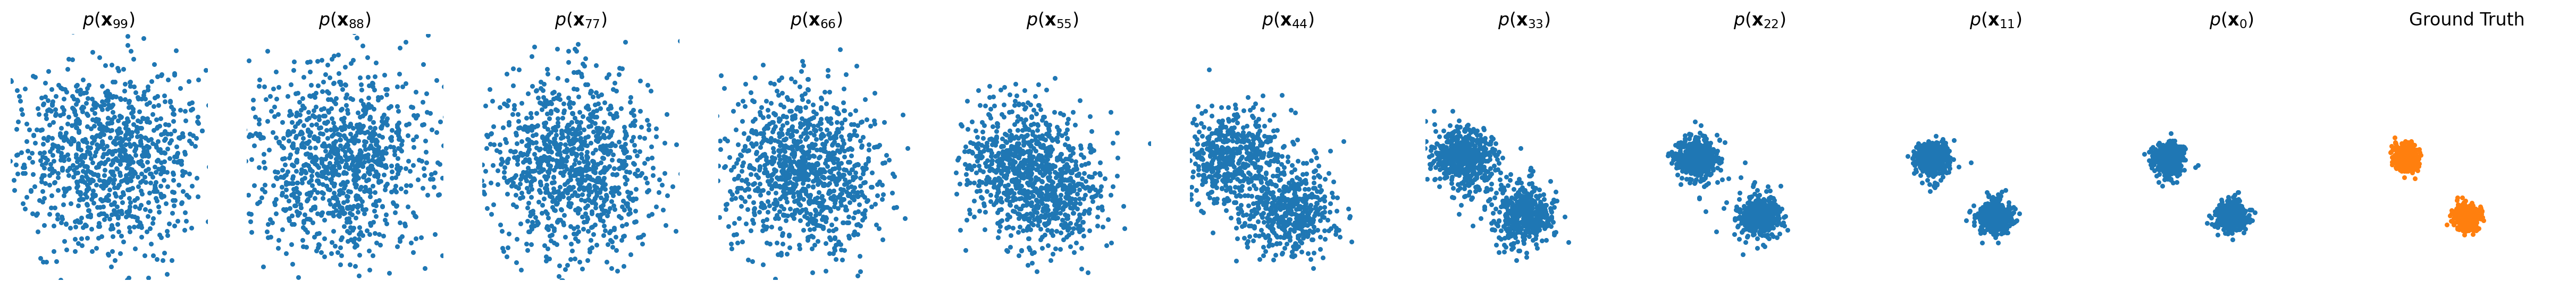

In [6]:
ground_cond = [-1.0, 0.0, 0.1, 0.0, -1.0, 0.1]

with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000, cond=torch.tensor([ground_cond]).to(device), return_steps=True
    ).cpu()

fig, axs = plt.subplots(1, 11, figsize=(31, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )
    axs[i].set_xlim(-2, 2)
    axs[i].set_ylim(-2, 2)

xy = np.stack([sampling(*ground_cond, n=1) for _ in range(1000)])
axs[-1].scatter(xy[:, 0], xy[:, 1], s=5, c="C1")
axs[-1].set_axis_off()
axs[-1].axis("equal")
axs[-1].set_title("Ground Truth")
axs[-1].set_xlim(-2, 2)
axs[-1].set_ylim(-2, 2)


(-2.0, 2.0)

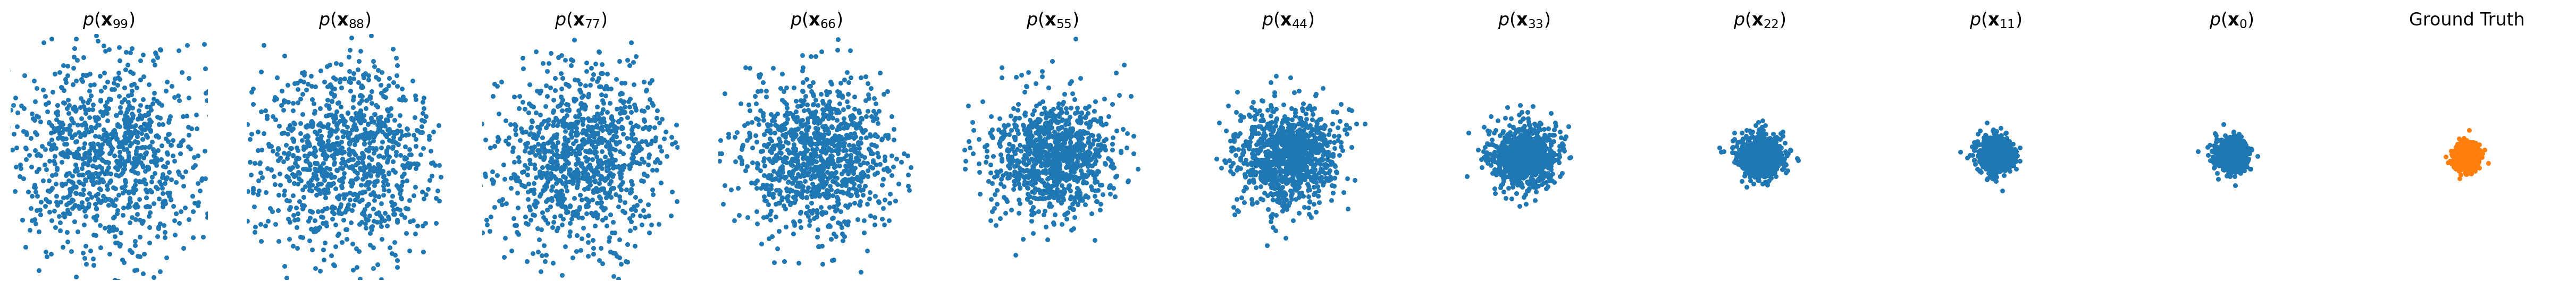

In [7]:
ground_cond = [0.0, 0.0, 0.1, 0.0, 0.0, 0.1]

with torch.inference_mode():
    x_seq = nn_model.p_sample_loop(
        size=1000, cond=torch.tensor([ground_cond]).to(device), return_steps=True
    ).cpu()

fig, axs = plt.subplots(1, 11, figsize=(31, 3))
for i in range(0, 10):
    cur_x = x_seq[i * 11]
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=5)
    axs[i].set_axis_off()
    axs[i].axis("equal")
    axs[i].set_title(
        f"$p(\\mathbf{{x}}_{{{int(nn_model.reversed_t_array[i*11].cpu()[0])}}})$"
    )
    axs[i].set_xlim(-2, 2)
    axs[i].set_ylim(-2, 2)

xy = np.stack([sampling(*ground_cond, n=1) for _ in range(1000)])
axs[-1].scatter(xy[:, 0], xy[:, 1], s=5, c="C1")
axs[-1].set_axis_off()
axs[-1].axis("equal")
axs[-1].set_title("Ground Truth")
axs[-1].set_xlim(-2, 2)
axs[-1].set_ylim(-2, 2)
